# deCIFer: Autoregressive Crystal Structure Generation Conditioned on X-ray Diffraction Data
---
## XRD Embeddings Analysis
    - Frederik Lizak Johansen
    - 26/11-2024
    - Chalmers

### Step 1: An easy example.
This is an example given by ChatGPT-4o on 26/11-24

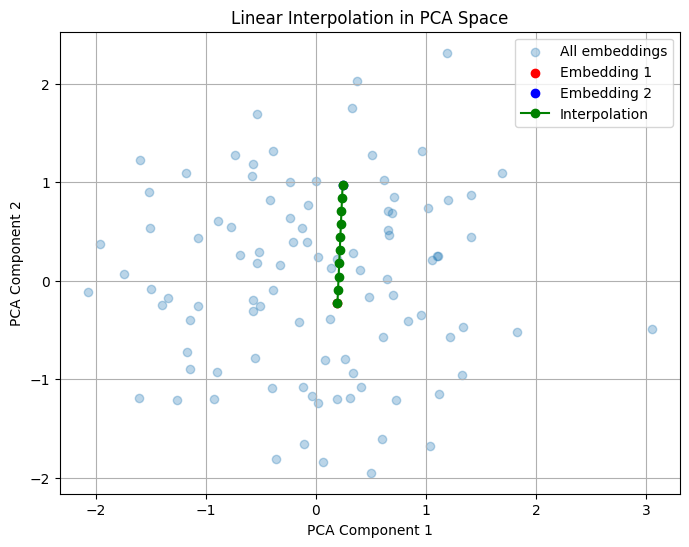

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Step 1: Generate some example 512-dimensional embeddings
np.random.seed(42)
embeddings = np.random.rand(100, 512)  # 100 embeddings, each with 512 dimensions

# Select two embeddings for interpolation
embedding1 = embeddings[0]
embedding2 = embeddings[1]

# Step 2: Apply PCA to reduce dimensions to 2D
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

# Project the two selected embeddings onto the PCA space
point1 = pca.transform(embedding1.reshape(1, -1))[0]
point2 = pca.transform(embedding2.reshape(1, -1))[0]

# Step 3: Interpolate between the two points in the 2D space
num_interpolations = 10
alphas = np.linspace(0, 1, num_interpolations)
interpolated_points = np.array([point1 * (1 - alpha) + point2 * alpha for alpha in alphas])

# Step 4: Visualize the interpolation in 2D space
plt.figure(figsize=(8, 6))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], alpha=0.3, label="All embeddings")
plt.scatter(*point1, color="red", label="Embedding 1")
plt.scatter(*point2, color="blue", label="Embedding 2")
plt.plot(interpolated_points[:, 0], interpolated_points[:, 1], color="green", marker="o", label="Interpolation")

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Linear Interpolation in PCA Space")
plt.legend()
plt.grid()
plt.show()

# Step 5: Map interpolated points back to 512-dimensional space
interpolated_embeddings = pca.inverse_transform(interpolated_points)

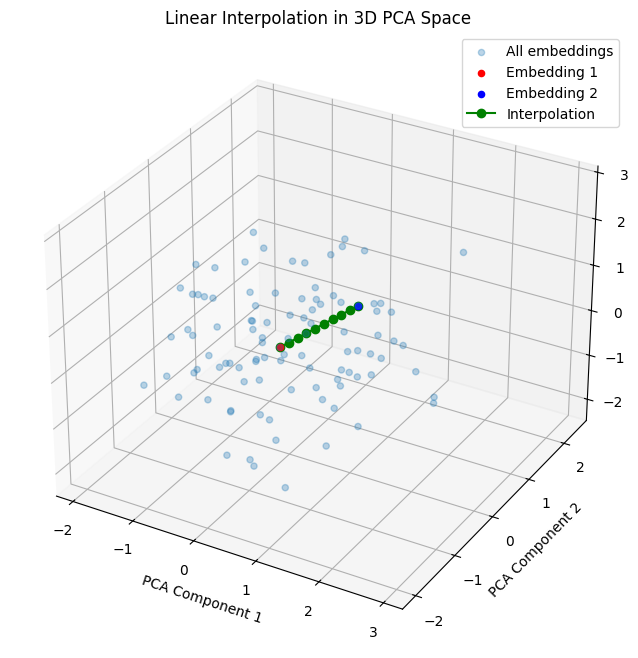

Shape of interpolated embeddings: (10, 512)


In [2]:

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

# Step 1: Generate some example 512-dimensional embeddings
np.random.seed(42)
embeddings = np.random.rand(100, 512)  # 100 embeddings, each with 512 dimensions

# Select two embeddings for interpolation
embedding1 = embeddings[0]
embedding2 = embeddings[1]

# Step 2: Apply PCA to reduce dimensions to 3D
pca = PCA(n_components=3)
reduced_embeddings = pca.fit_transform(embeddings)

# Project the two selected embeddings onto the PCA space
point1 = pca.transform(embedding1.reshape(1, -1))[0]
point2 = pca.transform(embedding2.reshape(1, -1))[0]

# Step 3: Interpolate between the two points in the 3D space
num_interpolations = 10
alphas = np.linspace(0, 1, num_interpolations)
interpolated_points = np.array([point1 * (1 - alpha) + point2 * alpha for alpha in alphas])

# Step 4: Visualize the interpolation in 3D space
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot all reduced embeddings
ax.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], reduced_embeddings[:, 2], alpha=0.3, label="All embeddings")
# Plot the two selected points
ax.scatter(*point1, color="red", label="Embedding 1")
ax.scatter(*point2, color="blue", label="Embedding 2")
# Plot the interpolated points
ax.plot(interpolated_points[:, 0], interpolated_points[:, 1], interpolated_points[:, 2], color="green", marker="o", label="Interpolation")

ax.set_xlabel("PCA Component 1")
ax.set_ylabel("PCA Component 2")
ax.set_zlabel("PCA Component 3")
ax.set_title("Linear Interpolation in 3D PCA Space")
ax.legend()
plt.show()

# Step 5: Map interpolated points back to 512-dimensional space
interpolated_embeddings = pca.inverse_transform(interpolated_points)

# Check the shape of the interpolated embeddings
print("Shape of interpolated embeddings:", interpolated_embeddings.shape)


### Step 2: Retrieving (real) XRD embeddings using the deCIFer dataset-class.

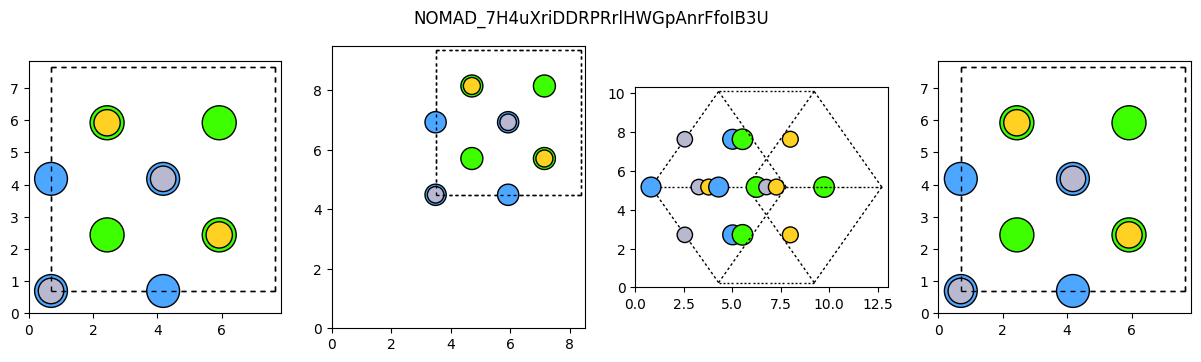

In [3]:
# Import class
from decifer.decifer_dataset import DeciferDataset

# Visualization
from pymatgen.core import Structure
from ase.build import bulk
from ase.visualize.plot import plot_atoms
import matplotlib.pyplot as plt

# Make new dataset, loading the data
h5_file_path = '../data/crystallm/full/serialized/test.h5'
dataset = DeciferDataset(h5_file_path, ['cif_name', 'cif_string', 'cif_tokenized', 'xrd_disc.q', 'xrd_disc.iq', 'spacegroup', 'species'])

# Visualization function
def show_cif_from_string(cif_string, title=None):
    fig, ax = plt.subplots(1, 4, figsize=(15, 5))
    structure_example = Structure.from_str(cif_string, fmt='cif').to_ase_atoms().repeat((1, 1, 1))
    plot_atoms(structure_example, ax[0], radii=0.3, rotation=('0x,0y,0z'))
    plot_atoms(structure_example, ax[1], scale=0.7, offset=(3, 4), radii=0.3, rotation=('0x,0y,0z'))
    plot_atoms(structure_example, ax[2], radii=0.3, rotation=('45x,45y,0z'))
    plot_atoms(structure_example, ax[3], radii=0.3, rotation=('0x,0y,0z'))
    if title is not None:
        fig.suptitle(title, y=0.85)
    plt.show()

# Show an example structure
show_cif_from_string(dataset[1]['cif_string'], dataset[1]['cif_name'])

### Step 3: Retrieving two specific crystal of interest (COI)
Here we look at finding two crystals with matching spacegroup and composition, but perhaps with flipped cation-anion or disimilar coordinates.

  0%|          | 0/1000 [00:00<?, ?it/s]

Spacegroup: P4mm, Species: ('B', 'K', 'Ta')
Matching indices: [45, 224]


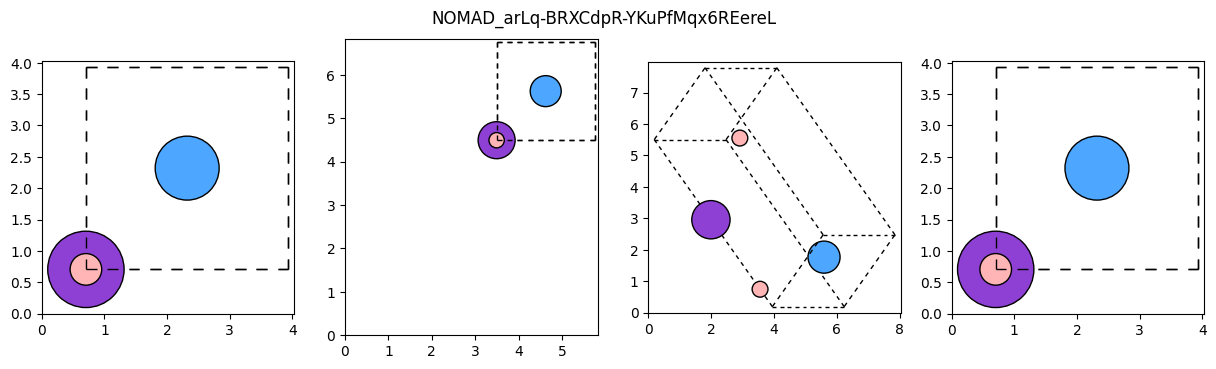

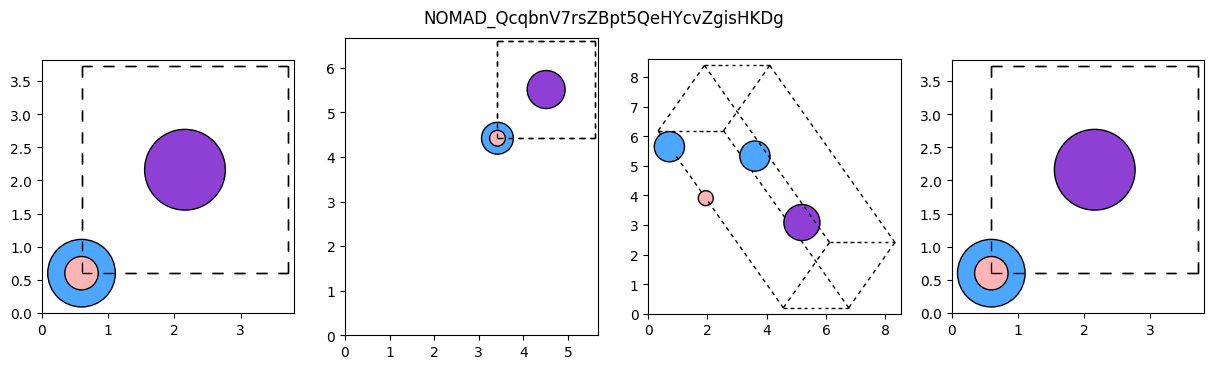

In [4]:
from collections import defaultdict
from tqdm.auto import tqdm

# Function to find matching spacegroup and species
def find_matching_structures(dataset, debug_max=None):
    # Group by spacegroup and sorted species list
    grouped = defaultdict(list)
    dataset_len = debug_max if debug_max is not None else len(dataset)
    pbar = tqdm(total=dataset_len)
    for idx, entry in enumerate(dataset):
        if debug_max is not None and idx >= debug_max:
            break
        species = entry['species'].split('"')[1::2]
        key = (entry['spacegroup'], tuple(sorted(species)))
        grouped[key].append(idx)
        pbar.update(1)
    pbar.close()

    # Filter groups with at least two entries
    matches = {key: indices for key, indices in grouped.items() if len(indices) > 1}
    return matches

debug_max = 1000
matches = find_matching_structures(dataset, debug_max)

# Display results
for key, indices in matches.items():
    print(f"Spacegroup: {key[0]}, Species: {key[1]}")
    print(f"Matching indices: {indices}")
    matching_structures = [dataset[i] for i in indices]

    for struc in matching_structures:
        show_cif_from_string(struc['cif_string'], title=struc['cif_name'])

    # Comment the following to visualize more than one match
    coi = matching_structures
    break

### Step 4: Loading the XRD conditioning embedder in question

In [5]:
# Import base model and dependencies
from decifer.decifer_model import Decifer, DeciferConfig
from bin.evaluate import load_model_from_checkpoint
import torch

# Ignore warnings from jupyter notebook (torch.load has leaking issues)
import warnings
warnings.simplefilter('ignore')

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load checkpoint and insert into model
model_ckpt_path = '../experiments/conditioned_mlp_augmentation/ckpt.pt'
model = load_model_from_checkpoint(model_ckpt_path, device)
model.eval()

# Extract XRD embedder
xrd_embedder = model.transformer.cond_embedding

number of total parameters: 26.14M


### Step 5: Embed all (or a given subset) of the datapoint and visualize the PC space

In [6]:
# Import data-to-xrd function
from decifer.utility import disc_to_cont_xrd

# Set length of PCA dataset
pca_debug_max = 5000
pca_dataset_len = pca_debug_max if pca_debug_max is not None else len(dataset)

# Initialize results list
results = []
embeddings = []
    
# Simulate, embed and save
pbar = tqdm(total=pca_dataset_len)
for idx, crystal in enumerate(dataset):

    # Break if debug max is reached
    if pca_debug_max is not None and idx >= pca_debug_max:
        break

    # Simulate
    out = disc_to_cont_xrd(
        crystal['xrd_disc.q'].unsqueeze(0),
        crystal['xrd_disc.iq'].unsqueeze(0),
        qmin = 0.0,
        qmax = 10.0,
        qstep = 0.01,
        fwhm_range = (0.05, 0.05),
        noise_range = None,
        mask_prob=None,
        intensity_scale_range=None
    )

    out['cif_name'] = crystal['cif_name']

    # Save
    out['xrd_cont.q'] = out['q']
    out['xrd_cont.iq'] = out['iq']

    # Embed and save
    with torch.no_grad():
        embd = xrd_embedder(out['iq'].to(device)).cpu().numpy().squeeze(0)
        embeddings.append(embd)
        out['embd'] = embd
        
    # Append to results
    results.append(out)

    # Update pbar
    pbar.update(1)
pbar.close()

embeddings = np.array(embeddings)

  0%|          | 0/5000 [00:00<?, ?it/s]

### Step 6: Specifically create the XRD patterns from the COI, and embed them using the XRD embedder

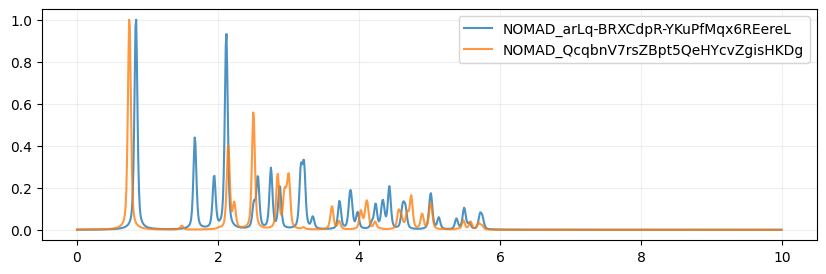

In [7]:
# Simulate, save and plot the results
fig, ax = plt.subplots(figsize=(10,3))
for i, crystal in enumerate(coi):

    # Simulate
    out = disc_to_cont_xrd(
        crystal['xrd_disc.q'].unsqueeze(0),
        crystal['xrd_disc.iq'].unsqueeze(0),
        qmin = 0.0,
        qmax = 10.0,
        qstep = 0.01,
        fwhm_range = (0.05, 0.05),
        noise_range = None,
        mask_prob=None,
        intensity_scale_range=None
    )

    # Save
    coi[i]['xrd_cont.q'] = out['q']
    coi[i]['xrd_cont.iq'] = out['iq'].squeeze(0)

    # Embed
    with torch.no_grad():
        coi[i]['embd'] = xrd_embedder(out['iq'].to(device)).cpu().numpy().squeeze(0)

    # Plot
    ax.plot(coi[i]['xrd_cont.q'],coi[i]['xrd_cont.iq'], label=crystal['cif_name'], alpha=0.8)

ax.legend()
ax.grid(alpha=0.2)
plt.show()

### Step 7: Perform PCA on all the embeddings and plot the two COI along with interpolations

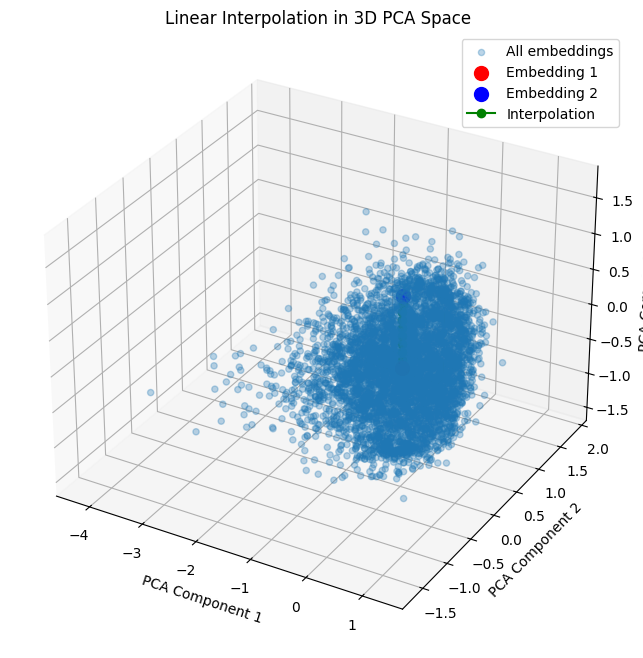

In [8]:
# Step 2: Apply PCA to reduce dimensions to 3D
pca = PCA(n_components=3)
reduced_embeddings = pca.fit_transform(embeddings)

# Project the two selected embeddings onto the PCA space
point1 = pca.transform(embedding1.reshape(1, -1))[0]
point2 = pca.transform(embedding2.reshape(1, -1))[0]

# Just come up with points
point1 = np.array([0.0,0.0,0.0])
point2 = np.array([0.0,0.0,1.0])

# Step 3: Interpolate between the two points in the 3D space
num_interpolations = 10
alphas = np.linspace(0, 1, num_interpolations)
interpolated_points = np.array([point1 * (1 - alpha) + point2 * alpha for alpha in alphas])

# Step 4: Visualize the interpolation in 3D space
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot all reduced embeddings
ax.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], reduced_embeddings[:, 2], alpha=0.3, label="All embeddings")
# Plot the two selected points
ax.scatter(*point1, color="red", label="Embedding 1", s=100, zorder=-1)
ax.scatter(*point2, color="blue", label="Embedding 2", s=100, zorder=-1)
# Plot the interpolated points
ax.plot(interpolated_points[:, 0], interpolated_points[:, 1], interpolated_points[:, 2], color="green", marker="o", label="Interpolation")

ax.set_xlabel("PCA Component 1")
ax.set_ylabel("PCA Component 2")
ax.set_zlabel("PCA Component 3")
ax.set_title("Linear Interpolation in 3D PCA Space")
ax.legend()
plt.show()

# Step 5: Map interpolated points back to 512-dimensional space
interpolated_embeddings = pca.inverse_transform(interpolated_points)

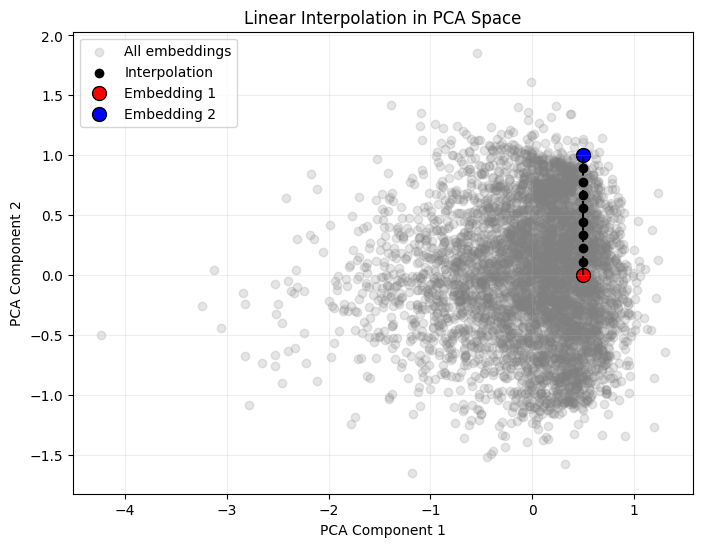

In [9]:
# Apply PCA to reduce dimensions to 2D
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

# Plot the PCA
point1 = pca.transform(coi[0]['embd'].reshape(1, -1))[0]
point2 = pca.transform(coi[1]['embd'].reshape(1, -1))[0]

# # Just come up with points
point1 = np.array([0.5,0.0])
point2 = np.array([0.5,1.0])

# Interpolate between the two points in the 2D space
num_interpolations = 10
alphas = np.linspace(0.0, 1.0, num_interpolations)
interpolated_points = np.array([point1 * (1 - alpha) + point2 * alpha for alpha in alphas])

# Visualize the interpolation in 2D space
plt.figure(figsize=(8, 6))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], alpha=0.2, label="All embeddings", c='grey')
plt.plot(interpolated_points[:, 0], interpolated_points[:, 1], color="k", ls='--', label=None)
plt.scatter(*interpolated_points.T, label="Interpolation", c='k')
plt.scatter(*point1, color="red", label="Embedding 1", edgecolor='k', s=100)
plt.scatter(*point2, color="blue", label="Embedding 2", edgecolor='k', s=100)

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Linear Interpolation in PCA Space")
plt.legend()
plt.grid(alpha=0.2)
plt.show()

# # Map interpolated points back to 512-dimensional space
interpolated_embeddings_from_data = pca.inverse_transform(interpolated_points)

#### Alternatively

In [96]:
# Interpolate in the 512-dimensional space
num_interpolations = 10
alphas = np.linspace(0, 1, num_interpolations)
interpolated_embeddings_from_data = np.array([embedding1 * (1 - alpha) + embedding2 * alpha for alpha in alphas])

### Step 8: Use the embeddings of the interpolation to generate CIFs and plot these

Generating sequence:   0%|          | 0/1000 [00:00<?, ?it/s]

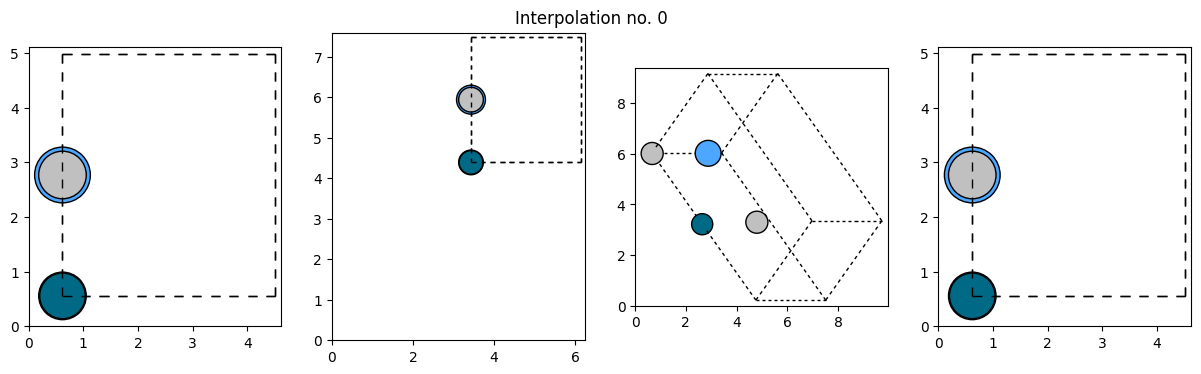

Generating sequence:   0%|          | 0/1000 [00:00<?, ?it/s]

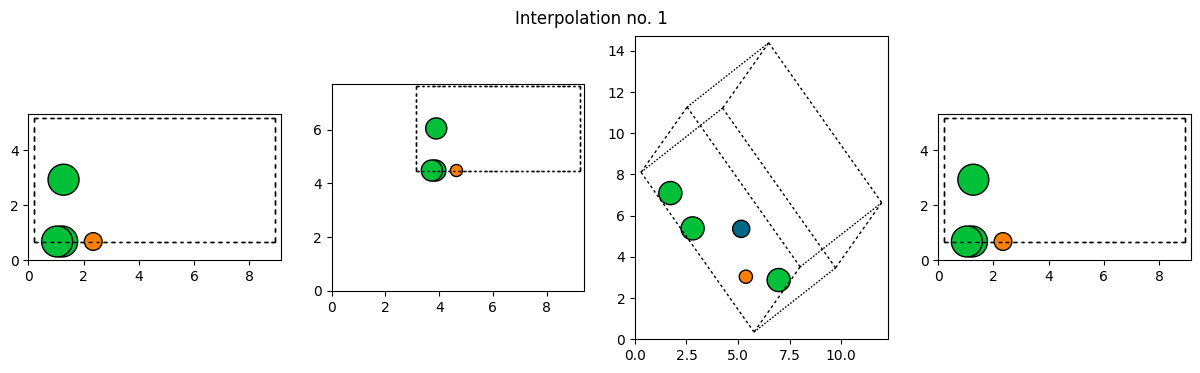

Generating sequence:   0%|          | 0/1000 [00:00<?, ?it/s]

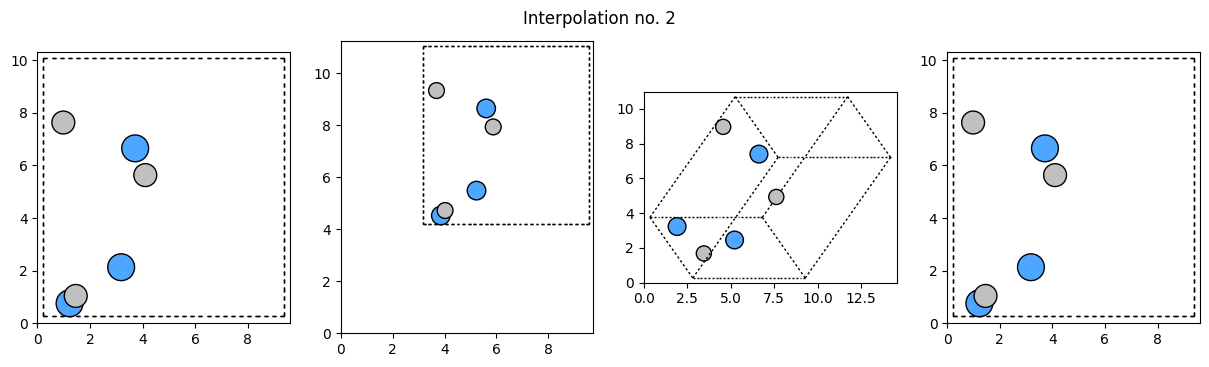

Generating sequence:   0%|          | 0/1000 [00:00<?, ?it/s]

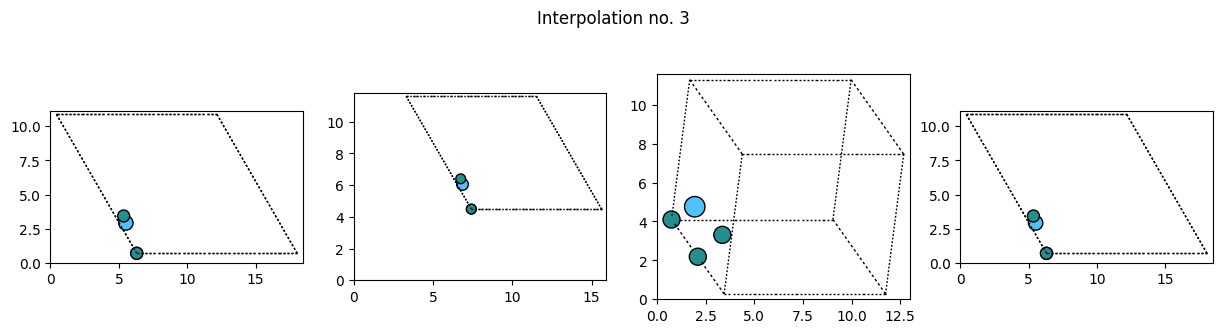

Generating sequence:   0%|          | 0/1000 [00:00<?, ?it/s]

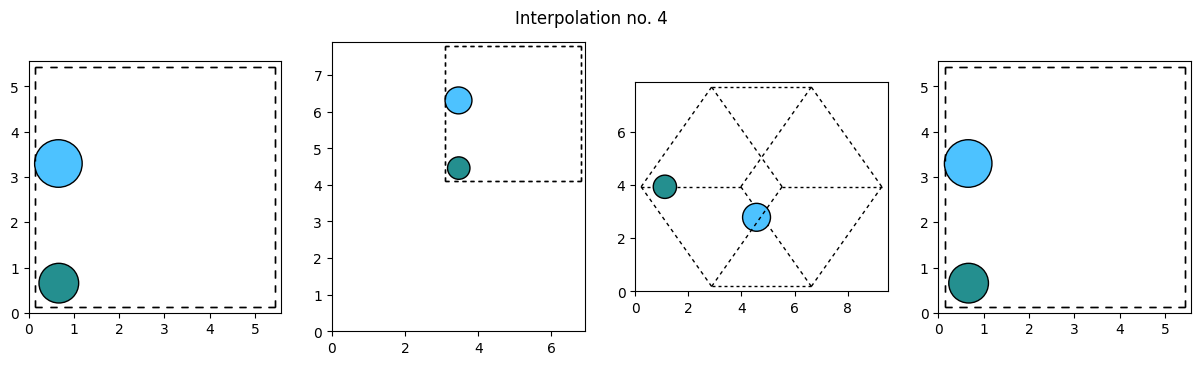

Generating sequence:   0%|          | 0/1000 [00:00<?, ?it/s]

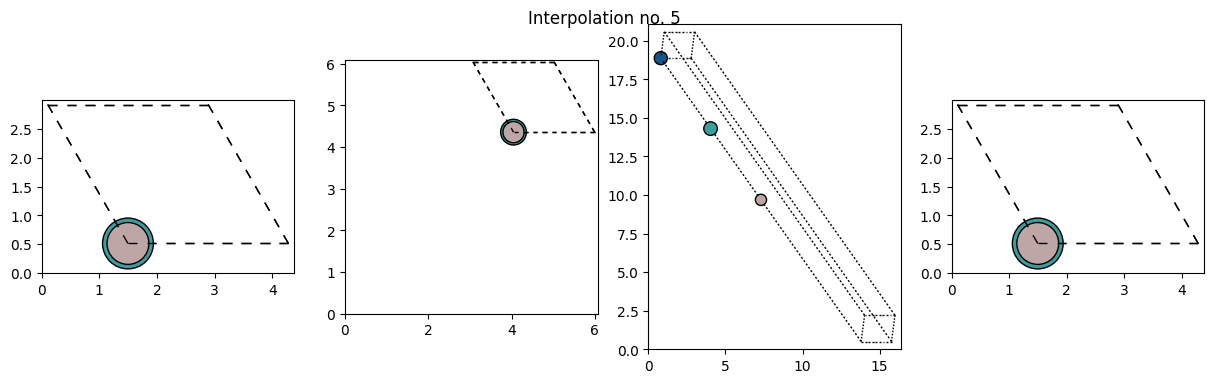

Generating sequence:   0%|          | 0/1000 [00:00<?, ?it/s]

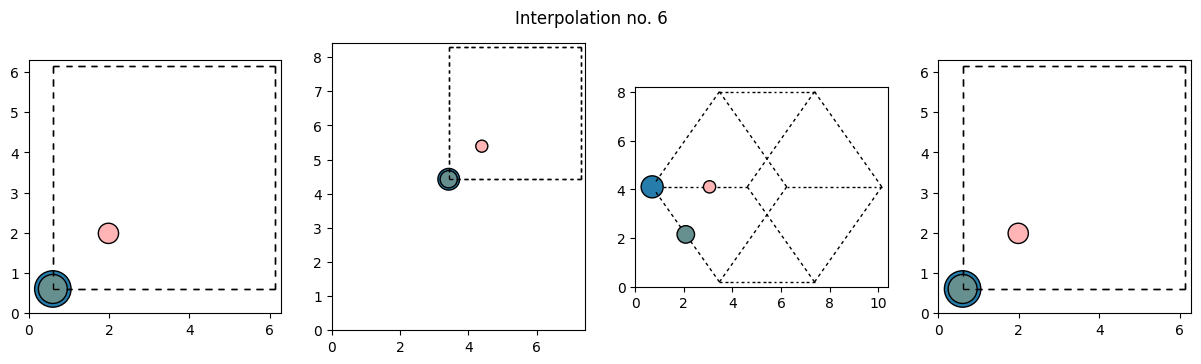

Generating sequence:   0%|          | 0/1000 [00:00<?, ?it/s]

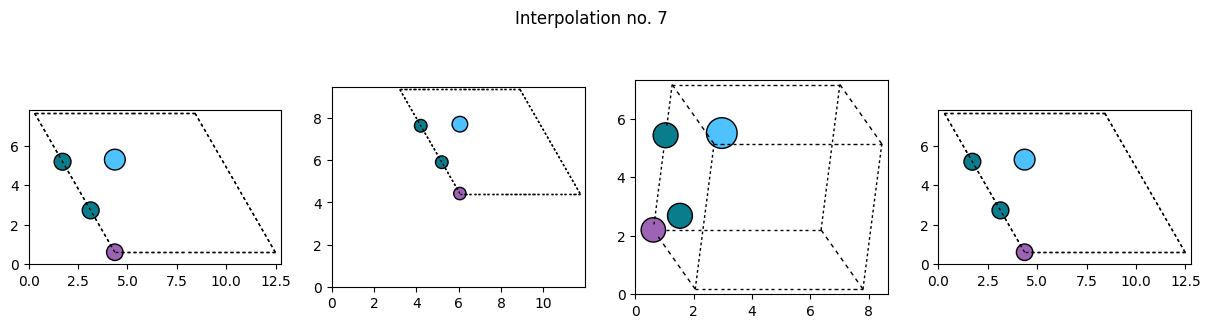

Generating sequence:   0%|          | 0/1000 [00:00<?, ?it/s]

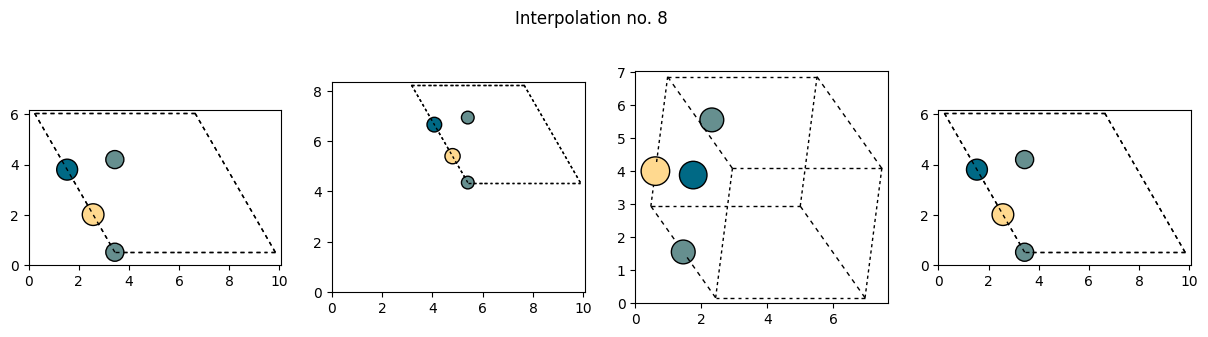

Generating sequence:   0%|          | 0/1000 [00:00<?, ?it/s]

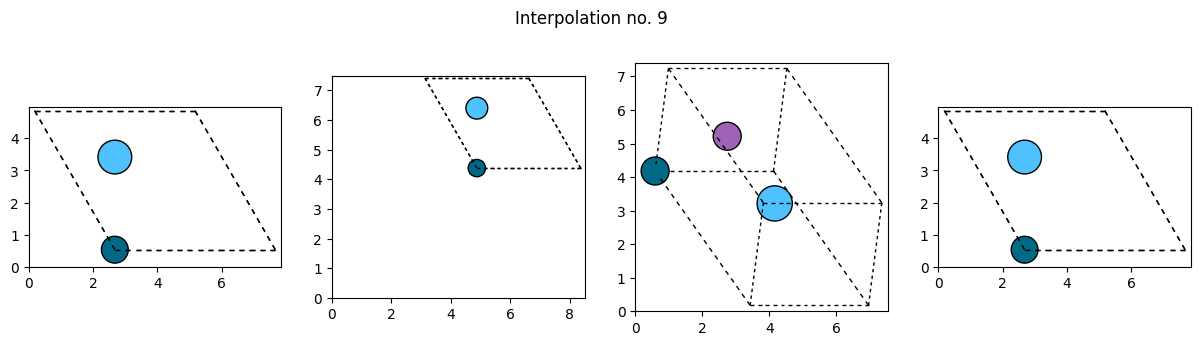

In [117]:
# Import tokenizer
from decifer.tokenizer import Tokenizer
tokenizer = Tokenizer()
padding_id = tokenizer.padding_id
decode = tokenizer.decode

# Import dependencies
from decifer.utility import (
    replace_symmetry_loop_with_P1,
    extract_space_group_symbol,
    reinstate_symmetry_loop,
    disc_to_cont_xrd_from_cif,
)

# Retrieve model excluding the embedder
model.transformer

# Get generic starting prompt
prompt = torch.tensor([[124]]).to(device)

# Loop through the embeddings, generate and plot
generated_xrd = []
for idx, embd in enumerate(interpolated_embeddings_from_data):

    # Move embedding to model device
    embd_tensor = torch.tensor(embd).unsqueeze(0).to(device, dtype=torch.float)
    
    # Generate CIF
    token_ids = model.generate_batched_reps(
        prompt,
        max_new_tokens=1000,
        cond_vec=None,
        start_indices_batch=[[0]],
        custom_cond_emb=embd_tensor,
    ).cpu().numpy()

    try:
        token_ids = [ids[ids != padding_id] for ids in token_ids]  # Remove padding tokens
        
        generated_cif_string = decode(list(token_ids[0]))
        generated_cif_string = replace_symmetry_loop_with_P1(generated_cif_string)
    
        # Extract space group symbol from the CIF string
        spacegroup_symbol = extract_space_group_symbol(generated_cif_string)
        
        # If the space group is not "P1", reinstate symmetry
        if spacegroup_symbol != "P 1":
            out_cif = reinstate_symmetry_loop(generated_cif_string, spacegroup_symbol)
        
        # Show the structure
        show_cif_from_string(generated_cif_string, title=f"Interpolation no. {idx}")
    
        # Gen new XRD and store for plotting
        xrd_gen = disc_to_cont_xrd_from_cif(
            out_cif,
            qmin = 0.0,
            qmax = 10.0,
            qstep = 0.01,
            fwhm_range = (0.05, 0.05),
            noise_range = None,
            mask_prob=None,
            intensity_scale_range=None,
        )
        
        # generated_structure.append()
        generated_xrd.append(xrd_gen['iq'])
    except:
        continue
    

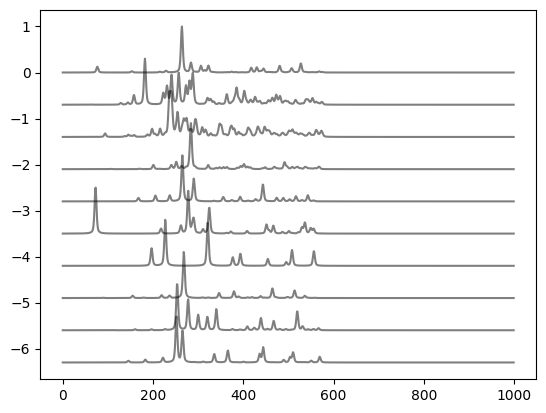

In [118]:
for i,xrd in enumerate(np.array(generated_xrd)):
    plt.plot(xrd-i*0.7, c='k', alpha=0.5)